In [35]:
import pandas as pd
import numpy as np
import csv
from operator import itemgetter
from Predictability import maximum_predictability
from Entropy import RealEntropy
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from statsmodels.tsa.stattools import adfuller
from LSTM import fit_LSTM
from collections import OrderedDict as OD
%matplotlib inline

In [2]:
filenames = ['201706-citibike-tripdata.csv', '201707-citibike-tripdata.csv', '201708-citibike-tripdata.csv']
outputs = ['June.csv', 'July.csv', 'August.csv']

def to_hour(starttime):
    return starttime[8:-6].split()[1]

def to_day(starttime):
    return starttime[8:-6].split()[0]

def record_2_timeseries(record):
    return [record[r] if r in record.index else 0 for r in range(720)]

def build_series(filename):
    df = pd.read_csv(filename, usecols=[1, 3])
    df.columns = ['datetime', 'id']
    print "Loaded data \n", df.head(5)
    df['hour'] = df['datetime'].apply(lambda x: to_hour(x))
    df['day'] = df['datetime'].apply(lambda x: to_day(x))
    df['hours'] =zip(df['hour'], df['day'])
    df['hours'] = df['hours'].apply(lambda xy: int(xy[0])+(int(xy[1])-1)*24)
    df = df[['id', 'hours']]
    stations = np.unique(df['id'])
    print "\nStations and pick-up hours \n", df.head(5)
    grouped = df.groupby(['id', 'hours']).size()
    print "\nAggregated per hour per station %s\n" % stations[0], grouped.get(stations[0])[:6]
    series = map(lambda station: record_2_timeseries(grouped.get(station)), stations)
    print "\nTime series \n", series[0][:10]
    return series, stations

In [3]:
station_series = []
station_list = []
for filename, output in zip(filenames, outputs):
    print "\nProcessing ", filename
    series, stations = build_series(filename)
    station_series.append(zip(stations, series))
    station_list.append(stations)
    with open(output, 'wb') as csvfile:
        writer = csv.writer(csvfile, quoting = csv.QUOTE_ALL)
        map(lambda ind: writer.writerow([stations[ind]]+series[ind]), range(len(series)))

print "Done."


Processing  201706-citibike-tripdata.csv
Loaded data 
              datetime    id
0  2017-06-01 00:00:02   515
1  2017-06-01 00:00:13   488
2  2017-06-01 00:00:20   461
3  2017-06-01 00:00:24  2009
4  2017-06-01 00:00:33   360

Stations and pick-up hours 
     id  hours
0   515      0
1   488      0
2   461      0
3  2009      0
4   360      0

Aggregated per hour per station 72
hours
0     4
5     2
6     1
7    11
8    10
9    15
dtype: int64

Time series 
[4, 0, 0, 0, 0, 2, 1, 11, 10, 15]

Processing  201707-citibike-tripdata.csv
Loaded data 
              datetime    id
0  2017-07-01 00:00:00   539
1  2017-07-01 00:00:03   293
2  2017-07-01 00:00:08  3242
3  2017-07-01 00:00:11  2002
4  2017-07-01 00:00:15  2002

Stations and pick-up hours 
     id  hours
0   539      0
1   293      0
2  3242      0
3  2002      0
4  2002      0

Aggregated per hour per station 72
hours
1    2
5    4
6    4
7    1
8    2
9    9
dtype: int64

Time series 
[0, 2, 0, 0, 0, 4, 4, 1, 2, 9]

Processing

In [4]:
station_dict = {}
#max(zip(map(len, stat), range(len(stat))), key = lambda x: x[0])[1]
station_list = sum(map(list, station_list), [])
for station in station_list:
    if station not in station_dict:
        station_dict[station] = 1
    else:
        station_dict[station] = station_dict[station] + 1

station_list = sorted(list(np.transpose(filter(lambda kv: kv[1]==3, station_dict.items()))[0]))

In [5]:
station_series = map(lambda statser: filter(lambda s: s[0] in station_list, statser), station_series)

In [6]:
station_series = map(lambda j: sum(map(lambda i: station_series[i][j][1], range(len(station_series))), []),
                     range(len(station_list)))

In [7]:
entropies = map(RealEntropy, station_series)

In [8]:
uniques = map(lambda x: len(np.unique(x)), station_series)

In [9]:
predictabilities = map(maximum_predictability, uniques, entropies)
predictabilities = map(lambda p: round(p, 2), predictabilities)

In [10]:
series = sorted(zip(station_list, predictabilities, station_series), key = lambda x: x[-2])

In [11]:
series = map(list, series)

In [12]:
with open('CitiBikeSeries.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, quoting = csv.QUOTE_ALL)
    map(lambda s: writer.writerow(sum([s[:2]] + s[2:], [])), series)

In [13]:
def drawSeries(timeseries, x_label, y_label, title, legends):
    fig, ax = plt.subplots(figsize = (18, 6))
    ax.set_xlim(0, len(timeseries[0]))
    #ax.set_ylim(0, np.max(timeseries)+1)
    for series_legend in zip(timeseries, legends):
        plots = ax.plot(series_legend[0], label = series_legend[1])
    plt.xlabel(x_label, fontsize = 17)
    plt.ylabel(y_label, fontsize = 17)
    plt.title(title, fontsize = 20)
    xticks = map(lambda tick: tick.label.set_fontsize(12), ax.xaxis.get_major_ticks())
    yticks = map(lambda tick: tick.label.set_fontsize(12), ax.yaxis.get_major_ticks())
    ax.grid(True)
    leg = plt.legend(fontsize = 22, frameon= True, edgecolor = 'black')

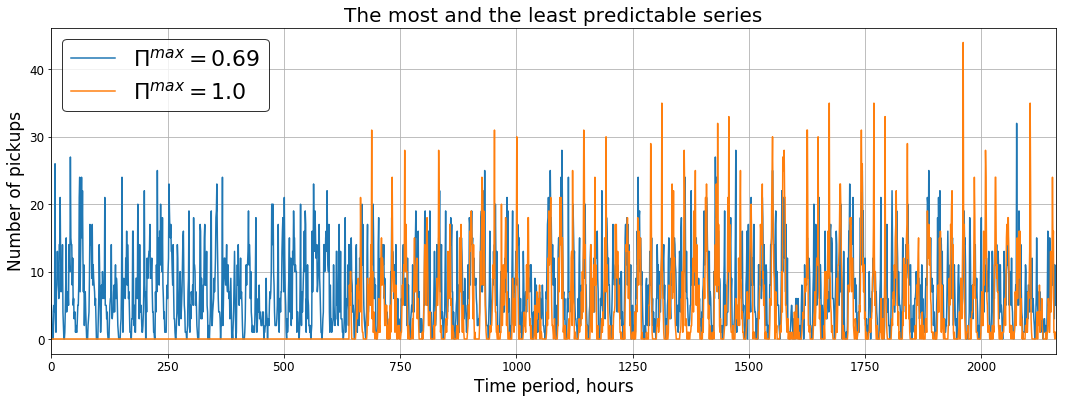

In [14]:
drawSeries([series[0][-1], series[-5][-1]], 'Time period, hours', 'Number of pickups',
           'The most and the least predictable series', 
           [r'$\Pi^{max}=$'+str(series[0][1]), r'$\Pi^{max}=$'+str(series[-1][1])])

In [15]:
bike_tests = map(lambda ts: adfuller(ts), station_series)
bike_test = map(lambda t: t[0], bike_tests)
bike_1perc = map(lambda t: t[-2]['1%'], bike_tests)
bike_5perc = map(lambda t: t[-2]['5%'], bike_tests)
bike_10perc = map(lambda t: t[-2]['10%'], bike_tests)

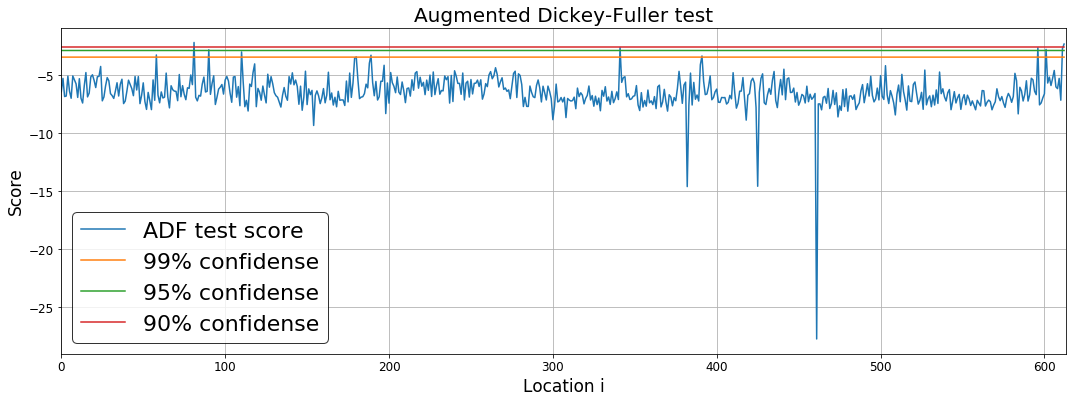

In [16]:
drawSeries([bike_test, bike_1perc, bike_5perc, bike_10perc], 'Location i', 'Score', 'Augmented Dickey-Fuller test', 
           ['ADF test score', '99% confidense', '95% confidense', '90% confidense'])

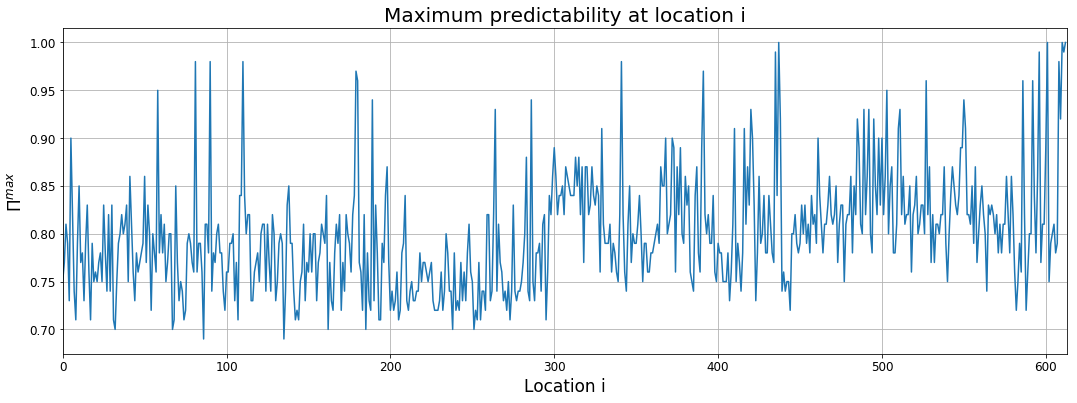

In [17]:
drawSeries([predictabilities], 'Location i', r'$\Pi^{max}$',
           'Maximum predictability at location i', [''])

In [18]:
filename = "CitiBikeSeries.csv"
with open(filename, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    #reader = filter(lambda features: features[-1] <> 'No solutions', reader)        
    #reader = sorted(reader, key = lambda x: x[-1])
    #timeseries = map(lambda features: map(lambda y: y.strip(), features[0].strip('[]').split(",")), [reader[0], reader[-1]])
    timeseries = map(lambda features: features, reader)
    least_errors = np.transpose(timeseries)[1]
    stations = np.transpose(timeseries)[0]
    timeseries = map(lambda features: features[2:], timeseries)

In [19]:
# Selecting representatives of each of 10% of Maximum Predictability intervals
indices = map(lambda i: len(timeseries)/10*i-len(timeseries)/20, range(1, 11))
timeseries = [timeseries[ind] for ind in indices] 

In [20]:
timeseries = map(lambda series: map(lambda ts: [float(ts)], series), timeseries)

In [21]:
lags =[2, 3, 4, 5, 6, 8, 10]#, 12, 16, 24]
num_layers = [2, 3, 4]
errors = []

In [23]:
print "Series #1"
series = timeseries[0]
current_errors = {}
for lag in lags:
    for n_layers in num_layers:
        print "Lag layers ", lag, n_layers
        current_errors['lag='+str(lag)+',layers='+str(n_layers)] = fit_LSTM(series, lag, 0.95, 2, n_layers)
errors.append(current_errors)
print current_errors

Series #1
Lag layers  2 2
Lag layers  2 3
Lag layers  2 4
Lag layers  3 2
Lag layers  3 3
Lag layers  3 4
Lag layers  4 2
Lag layers  4 3
Lag layers  4 4
Lag layers  5 2
Lag layers  5 3
Lag layers  5 4
Lag layers  6 2
Lag layers  6 3
Lag layers  6 4
Lag layers  8 2
Lag layers  8 3
Lag layers  8 4
Lag layers  10 2
Lag layers  10 3
Lag layers  10 4
{'lag=8,layers=4': 6.4279108592498435, 'lag=10,layers=3': 6.239822755934839, 'lag=8,layers=2': 6.452297508041405, 'lag=8,layers=3': 6.175465450946683, 'lag=3,layers=3': 7.375438778618897, 'lag=3,layers=2': 6.686551029352146, 'lag=10,layers=2': 6.524832321914998, 'lag=4,layers=4': 7.921636885389426, 'lag=3,layers=4': 7.5057805884372115, 'lag=4,layers=2': 6.675506352415777, 'lag=5,layers=3': 7.155972823124983, 'lag=5,layers=2': 6.605543724694038, 'lag=5,layers=4': 7.543113979418912, 'lag=4,layers=3': 7.079406303174357, 'lag=2,layers=4': 7.663038157634514, 'lag=10,layers=4': 6.163803131413626, 'lag=6,layers=2': 6.579175676570307, 'lag=6,layers=3'

In [24]:
print "Series #2"
series = timeseries[1]
current_errors = {}
for lag in lags:
    for n_layers in num_layers:
        print "Lag layers ", lag, n_layers
        current_errors['lag='+str(lag)+',layers='+str(n_layers)] = fit_LSTM(series, lag, 0.95, 2, n_layers)
errors.append(current_errors)
print current_errors

Series #2
Lag layers  2 2
Lag layers  2 3
Lag layers  2 4
Lag layers  3 2
Lag layers  3 3
Lag layers  3 4
Lag layers  4 2
Lag layers  4 3
Lag layers  4 4
Lag layers  5 2
Lag layers  5 3
Lag layers  5 4
Lag layers  6 2
Lag layers  6 3
Lag layers  6 4
Lag layers  8 2
Lag layers  8 3
Lag layers  8 4
Lag layers  10 2
Lag layers  10 3
Lag layers  10 4
{'lag=8,layers=4': 5.726350149912092, 'lag=10,layers=3': 5.145441608871985, 'lag=8,layers=2': 5.167150435812424, 'lag=8,layers=3': 4.942496593143226, 'lag=3,layers=3': 5.545126818077202, 'lag=3,layers=2': 5.4573128973698735, 'lag=10,layers=2': 5.0559593657590085, 'lag=4,layers=4': 6.011747514071176, 'lag=3,layers=4': 6.180163167648116, 'lag=4,layers=2': 5.394405918016688, 'lag=5,layers=3': 5.690211996580315, 'lag=5,layers=2': 5.082636182804391, 'lag=5,layers=4': 6.373900832305634, 'lag=4,layers=3': 5.977470708324923, 'lag=2,layers=4': 6.789514106168091, 'lag=10,layers=4': 5.01572277087599, 'lag=6,layers=2': 5.143550260334483, 'lag=6,layers=3':

In [25]:
print "Series #3"
series = timeseries[2]
current_errors = {}
for lag in lags:
    for n_layers in num_layers:
        print "Lag layers ", lag, n_layers
        current_errors['lag='+str(lag)+',layers='+str(n_layers)] = fit_LSTM(series, lag, 0.95, 2, n_layers)
errors.append(current_errors)
print current_errors

Series #3
Lag layers  2 2
Lag layers  2 3
Lag layers  2 4
Lag layers  3 2
Lag layers  3 3
Lag layers  3 4
Lag layers  4 2
Lag layers  4 3
Lag layers  4 4
Lag layers  5 2
Lag layers  5 3
Lag layers  5 4
Lag layers  6 2
Lag layers  6 3
Lag layers  6 4
Lag layers  8 2
Lag layers  8 3
Lag layers  8 4
Lag layers  10 2
Lag layers  10 3
Lag layers  10 4
{'lag=8,layers=4': 6.708930848292239, 'lag=10,layers=3': 6.796906678166743, 'lag=8,layers=2': 6.693424090334069, 'lag=8,layers=3': 6.524577165999543, 'lag=3,layers=3': 8.077486576845567, 'lag=3,layers=2': 6.990496889297274, 'lag=10,layers=2': 6.591122284023711, 'lag=4,layers=4': 8.381327138951338, 'lag=3,layers=4': 8.045430260254332, 'lag=4,layers=2': 7.307101966975597, 'lag=5,layers=3': 6.7485739395237205, 'lag=5,layers=2': 7.278128890354484, 'lag=5,layers=4': 8.30168203446953, 'lag=4,layers=3': 8.393249725750504, 'lag=2,layers=4': 8.287328570291933, 'lag=10,layers=4': 6.759910659780335, 'lag=6,layers=2': 6.400641590612253, 'lag=6,layers=3': 

In [26]:
print "Series #4"
series = timeseries[3]
current_errors = {}
for lag in lags:
    for n_layers in num_layers:
        print "Lag layers ", lag, n_layers
        current_errors['lag='+str(lag)+',layers='+str(n_layers)] = fit_LSTM(series, lag, 0.95, 2, n_layers)
errors.append(current_errors)
print current_errors

Series #4
Lag layers  2 2
Lag layers  2 3
Lag layers  2 4
Lag layers  3 2
Lag layers  3 3
Lag layers  3 4
Lag layers  4 2
Lag layers  4 3
Lag layers  4 4
Lag layers  5 2
Lag layers  5 3
Lag layers  5 4
Lag layers  6 2
Lag layers  6 3
Lag layers  6 4
Lag layers  8 2
Lag layers  8 3
Lag layers  8 4
Lag layers  10 2
Lag layers  10 3
Lag layers  10 4
{'lag=8,layers=4': 2.9589277072441886, 'lag=10,layers=3': 2.7567377568353613, 'lag=8,layers=2': 2.7122700569111964, 'lag=8,layers=3': 2.5855518654503977, 'lag=3,layers=3': 3.077766776079921, 'lag=3,layers=2': 2.949075963284735, 'lag=10,layers=2': 2.708510558061368, 'lag=4,layers=4': 3.366622136328, 'lag=3,layers=4': 3.22011076513726, 'lag=4,layers=2': 2.876634281141331, 'lag=5,layers=3': 3.155331832623044, 'lag=5,layers=2': 2.7749778665547042, 'lag=5,layers=4': 3.2704001380369303, 'lag=4,layers=3': 3.0214612214139396, 'lag=2,layers=4': 3.2074728542224555, 'lag=10,layers=4': 2.465947485293477, 'lag=6,layers=2': 2.718188089836726, 'lag=6,layers=

In [27]:
print "Series #5"
series = timeseries[4]
current_errors = {}
for lag in lags:
    for n_layers in num_layers:
        print "Lag layers ", lag, n_layers
        current_errors['lag='+str(lag)+',layers='+str(n_layers)] = fit_LSTM(series, lag, 0.95, 2, n_layers)
errors.append(current_errors)
print current_errors

Series #5
Lag layers  2 2
Lag layers  2 3
Lag layers  2 4
Lag layers  3 2
Lag layers  3 3
Lag layers  3 4
Lag layers  4 2
Lag layers  4 3
Lag layers  4 4
Lag layers  5 2
Lag layers  5 3
Lag layers  5 4
Lag layers  6 2
Lag layers  6 3
Lag layers  6 4
Lag layers  8 2
Lag layers  8 3
Lag layers  8 4
Lag layers  10 2
Lag layers  10 3
Lag layers  10 4
{'lag=8,layers=4': 2.2530690096449306, 'lag=10,layers=3': 2.152389610552331, 'lag=8,layers=2': 2.1465407838097854, 'lag=8,layers=3': 2.1720001863211005, 'lag=3,layers=3': 2.3008153481719775, 'lag=3,layers=2': 2.190148806535047, 'lag=10,layers=2': 2.1945830055309368, 'lag=4,layers=4': 2.474206348596058, 'lag=3,layers=4': 2.2356308098345243, 'lag=4,layers=2': 2.2462658058002942, 'lag=5,layers=3': 2.3712747040901876, 'lag=5,layers=2': 2.206949251936062, 'lag=5,layers=4': 2.3550366428245444, 'lag=4,layers=3': 2.368680075468635, 'lag=2,layers=4': 2.4349192160770823, 'lag=10,layers=4': 2.2297782553528815, 'lag=6,layers=2': 2.171772413187481, 'lag=6,

In [28]:
print "Series #6"
series = timeseries[5]
current_errors = {}
for lag in lags:
    for n_layers in num_layers:
        print "Lag layers ", lag, n_layers
        current_errors['lag='+str(lag)+',layers='+str(n_layers)] = fit_LSTM(series, lag, 0.95, 2, n_layers)
errors.append(current_errors)
print current_errors

Series #6
Lag layers  2 2
Lag layers  2 3
Lag layers  2 4
Lag layers  3 2
Lag layers  3 3
Lag layers  3 4
Lag layers  4 2
Lag layers  4 3
Lag layers  4 4
Lag layers  5 2
Lag layers  5 3
Lag layers  5 4
Lag layers  6 2
Lag layers  6 3
Lag layers  6 4
Lag layers  8 2
Lag layers  8 3
Lag layers  8 4
Lag layers  10 2
Lag layers  10 3
Lag layers  10 4
{'lag=8,layers=4': 2.377238797651176, 'lag=10,layers=3': 2.262296483926266, 'lag=8,layers=2': 2.3761971541967135, 'lag=8,layers=3': 2.2683279515951207, 'lag=3,layers=3': 2.8773417642732273, 'lag=3,layers=2': 2.671151889921639, 'lag=10,layers=2': 2.302568433403697, 'lag=4,layers=4': 2.755910291342041, 'lag=3,layers=4': 2.8423256163511708, 'lag=4,layers=2': 2.420665555671325, 'lag=5,layers=3': 2.722577454377005, 'lag=5,layers=2': 2.4910720200679553, 'lag=5,layers=4': 2.7409657195943766, 'lag=4,layers=3': 2.720632598092471, 'lag=2,layers=4': 2.978502640458829, 'lag=10,layers=4': 2.3159954823091806, 'lag=6,layers=2': 2.4512497691081934, 'lag=6,lay

In [29]:
print "Series #7"
series = timeseries[6]
current_errors = {}
for lag in lags:
    for n_layers in num_layers:
        print "Lag layers ", lag, n_layers
        current_errors['lag='+str(lag)+',layers='+str(n_layers)] = fit_LSTM(series, lag, 0.95, 2, n_layers)
errors.append(current_errors)
print current_errors

Series #7
Lag layers  2 2
Lag layers  2 3
Lag layers  2 4
Lag layers  3 2
Lag layers  3 3
Lag layers  3 4
Lag layers  4 2
Lag layers  4 3
Lag layers  4 4
Lag layers  5 2
Lag layers  5 3
Lag layers  5 4
Lag layers  6 2
Lag layers  6 3
Lag layers  6 4
Lag layers  8 2
Lag layers  8 3
Lag layers  8 4
Lag layers  10 2
Lag layers  10 3
Lag layers  10 4
{'lag=8,layers=4': 1.4583020115162295, 'lag=10,layers=3': 1.411260902576041, 'lag=8,layers=2': 1.3921841852659411, 'lag=8,layers=3': 1.4495982109381553, 'lag=3,layers=3': 1.5481616310987631, 'lag=3,layers=2': 1.550008981462496, 'lag=10,layers=2': 1.3804831533492743, 'lag=4,layers=4': 1.5764089190360078, 'lag=3,layers=4': 1.5835985040414366, 'lag=4,layers=2': 1.5123199875307192, 'lag=5,layers=3': 1.5915930761859374, 'lag=5,layers=2': 1.5251166987185982, 'lag=5,layers=4': 1.5889428005537443, 'lag=4,layers=3': 1.5979028300217533, 'lag=2,layers=4': 1.6567905590557113, 'lag=10,layers=4': 1.4720370433042218, 'lag=6,layers=2': 1.5006072300861062, 'la

In [30]:
print "Series #8"
series = timeseries[7]
current_errors = {}
for lag in lags:
    for n_layers in num_layers:
        print "Lag layers ", lag, n_layers
        current_errors['lag='+str(lag)+',layers='+str(n_layers)] = fit_LSTM(series, lag, 0.95, 2, n_layers)
errors.append(current_errors)
print current_errors

Series #8
Lag layers  2 2
Lag layers  2 3
Lag layers  2 4
Lag layers  3 2
Lag layers  3 3
Lag layers  3 4
Lag layers  4 2
Lag layers  4 3
Lag layers  4 4
Lag layers  5 2
Lag layers  5 3
Lag layers  5 4
Lag layers  6 2
Lag layers  6 3
Lag layers  6 4
Lag layers  8 2
Lag layers  8 3
Lag layers  8 4
Lag layers  10 2
Lag layers  10 3
Lag layers  10 4
{'lag=8,layers=4': 2.455679165679514, 'lag=10,layers=3': 2.35732865221894, 'lag=8,layers=2': 2.4863854733165516, 'lag=8,layers=3': 2.448715418622982, 'lag=3,layers=3': 2.8068087947238216, 'lag=3,layers=2': 2.8262020032802386, 'lag=10,layers=2': 2.3942042117223177, 'lag=4,layers=4': 2.9436181223715985, 'lag=3,layers=4': 2.7117751679464055, 'lag=4,layers=2': 2.8077505549011965, 'lag=5,layers=3': 2.764665282618108, 'lag=5,layers=2': 2.7157473187004513, 'lag=5,layers=4': 3.4303616319170347, 'lag=4,layers=3': 2.7439197352194555, 'lag=2,layers=4': 3.1939508271946075, 'lag=10,layers=4': 2.400545922874755, 'lag=6,layers=2': 2.4370740562902937, 'lag=6,

In [31]:
print "Series #9"
series = timeseries[8]
current_errors = {}
for lag in lags:
    for n_layers in num_layers:
        print "Lag layers ", lag, n_layers
        current_errors['lag='+str(lag)+',layers='+str(n_layers)] = fit_LSTM(series, lag, 0.95, 2, n_layers)
errors.append(current_errors)
print current_errors

Series #9
Lag layers  2 2
Lag layers  2 3
Lag layers  2 4
Lag layers  3 2
Lag layers  3 3
Lag layers  3 4
Lag layers  4 2
Lag layers  4 3
Lag layers  4 4
Lag layers  5 2
Lag layers  5 3
Lag layers  5 4
Lag layers  6 2
Lag layers  6 3
Lag layers  6 4
Lag layers  8 2
Lag layers  8 3
Lag layers  8 4
Lag layers  10 2
Lag layers  10 3
Lag layers  10 4
{'lag=8,layers=4': 1.2515874377069747, 'lag=10,layers=3': 1.084507285194836, 'lag=8,layers=2': 1.1038464118456832, 'lag=8,layers=3': 1.0903567312228397, 'lag=3,layers=3': 1.1263073362719416, 'lag=3,layers=2': 1.1107626152272705, 'lag=10,layers=2': 1.1056924543230608, 'lag=4,layers=4': 1.1660648475282125, 'lag=3,layers=4': 1.119901720137625, 'lag=4,layers=2': 1.1096022904514908, 'lag=5,layers=3': 1.1254406079863142, 'lag=5,layers=2': 1.1157128226352755, 'lag=5,layers=4': 1.1486161459738349, 'lag=4,layers=3': 1.1351136515450195, 'lag=2,layers=4': 1.1094332521387342, 'lag=10,layers=4': 1.0978162363993564, 'lag=6,layers=2': 1.108967543281708, 'lag

In [32]:
print "Series #10"
series = timeseries[9]
current_errors = {}
for lag in lags:
    for n_layers in num_layers:
        print "Lag layers ", lag, n_layers
        current_errors['lag='+str(lag)+',layers='+str(n_layers)] = fit_LSTM(series, lag, 0.95, 2, n_layers)
errors.append(current_errors)
print current_errors

Series #10
Lag layers  2 2
Lag layers  2 3
Lag layers  2 4
Lag layers  3 2
Lag layers  3 3
Lag layers  3 4
Lag layers  4 2
Lag layers  4 3
Lag layers  4 4
Lag layers  5 2
Lag layers  5 3
Lag layers  5 4
Lag layers  6 2
Lag layers  6 3
Lag layers  6 4
Lag layers  8 2
Lag layers  8 3
Lag layers  8 4
Lag layers  10 2
Lag layers  10 3
Lag layers  10 4
{'lag=8,layers=4': 0.5795530564607784, 'lag=10,layers=3': 0.5829241717748401, 'lag=8,layers=2': 0.5814997619272442, 'lag=8,layers=3': 0.5798543542043564, 'lag=3,layers=3': 0.5760639168707197, 'lag=3,layers=2': 0.5744907829017586, 'lag=10,layers=2': 0.5861888016511386, 'lag=4,layers=4': 0.5782506636857043, 'lag=3,layers=4': 0.5756334293861751, 'lag=4,layers=2': 0.5774908813462647, 'lag=5,layers=3': 0.5776810293189912, 'lag=5,layers=2': 0.5768560098795853, 'lag=5,layers=4': 0.5770202328399902, 'lag=4,layers=3': 0.5782323647732438, 'lag=2,layers=4': 0.573584340298253, 'lag=10,layers=4': 0.5836624024969759, 'lag=6,layers=2': 0.576474915594919, 'l

In [33]:
results = []
results.append({'lag=8,layers=4': 6.4279108592498435, 'lag=10,layers=3': 6.239822755934839, 'lag=8,layers=2': 6.452297508041405, 'lag=8,layers=3': 6.175465450946683, 'lag=3,layers=3': 7.375438778618897, 'lag=3,layers=2': 6.686551029352146, 'lag=10,layers=2': 6.524832321914998, 'lag=4,layers=4': 7.921636885389426, 'lag=3,layers=4': 7.5057805884372115, 'lag=4,layers=2': 6.675506352415777, 'lag=5,layers=3': 7.155972823124983, 'lag=5,layers=2': 6.605543724694038, 'lag=5,layers=4': 7.543113979418912, 'lag=4,layers=3': 7.079406303174357, 'lag=2,layers=4': 7.663038157634514, 'lag=10,layers=4': 6.163803131413626, 'lag=6,layers=2': 6.579175676570307, 'lag=6,layers=3': 7.08151941200454, 'lag=6,layers=4': 7.679274061044968, 'lag=2,layers=2': 7.0193769896027876, 'lag=2,layers=3': 7.057156171819004})
results.append({'lag=8,layers=4': 5.726350149912092, 'lag=10,layers=3': 5.145441608871985, 'lag=8,layers=2': 5.167150435812424, 'lag=8,layers=3': 4.942496593143226, 'lag=3,layers=3': 5.545126818077202, 'lag=3,layers=2': 5.4573128973698735, 'lag=10,layers=2': 5.0559593657590085, 'lag=4,layers=4': 6.011747514071176, 'lag=3,layers=4': 6.180163167648116, 'lag=4,layers=2': 5.394405918016688, 'lag=5,layers=3': 5.690211996580315, 'lag=5,layers=2': 5.082636182804391, 'lag=5,layers=4': 6.373900832305634, 'lag=4,layers=3': 5.977470708324923, 'lag=2,layers=4': 6.789514106168091, 'lag=10,layers=4': 5.01572277087599, 'lag=6,layers=2': 5.143550260334483, 'lag=6,layers=3': 6.057217046176677, 'lag=6,layers=4': 6.334977147086471, 'lag=2,layers=2': 5.388107525659436, 'lag=2,layers=3': 5.803520663242369})
results.append({'lag=8,layers=4': 6.708930848292239, 'lag=10,layers=3': 6.796906678166743, 'lag=8,layers=2': 6.693424090334069, 'lag=8,layers=3': 6.524577165999543, 'lag=3,layers=3': 8.077486576845567, 'lag=3,layers=2': 6.990496889297274, 'lag=10,layers=2': 6.591122284023711, 'lag=4,layers=4': 8.381327138951338, 'lag=3,layers=4': 8.045430260254332, 'lag=4,layers=2': 7.307101966975597, 'lag=5,layers=3': 6.7485739395237205, 'lag=5,layers=2': 7.278128890354484, 'lag=5,layers=4': 8.30168203446953, 'lag=4,layers=3': 8.393249725750504, 'lag=2,layers=4': 8.287328570291933, 'lag=10,layers=4': 6.759910659780335, 'lag=6,layers=2': 6.400641590612253, 'lag=6,layers=3': 7.230256773977162, 'lag=6,layers=4': 8.953815291084503, 'lag=2,layers=2': 7.3783765079784205, 'lag=2,layers=3': 7.483156866662515})
results.append({'lag=8,layers=4': 2.9589277072441886, 'lag=10,layers=3': 2.7567377568353613, 'lag=8,layers=2': 2.7122700569111964, 'lag=8,layers=3': 2.5855518654503977, 'lag=3,layers=3': 3.077766776079921, 'lag=3,layers=2': 2.949075963284735, 'lag=10,layers=2': 2.708510558061368, 'lag=4,layers=4': 3.366622136328, 'lag=3,layers=4': 3.22011076513726, 'lag=4,layers=2': 2.876634281141331, 'lag=5,layers=3': 3.155331832623044, 'lag=5,layers=2': 2.7749778665547042, 'lag=5,layers=4': 3.2704001380369303, 'lag=4,layers=3': 3.0214612214139396, 'lag=2,layers=4': 3.2074728542224555, 'lag=10,layers=4': 2.465947485293477, 'lag=6,layers=2': 2.718188089836726, 'lag=6,layers=3': 2.705382213375237, 'lag=6,layers=4': 2.8932893249725393, 'lag=2,layers=2': 2.811253158453769, 'lag=2,layers=3': 3.1008973496259524})
results.append({'lag=8,layers=4': 2.2530690096449306, 'lag=10,layers=3': 2.152389610552331, 'lag=8,layers=2': 2.1465407838097854, 'lag=8,layers=3': 2.1720001863211005, 'lag=3,layers=3': 2.3008153481719775, 'lag=3,layers=2': 2.190148806535047, 'lag=10,layers=2': 2.1945830055309368, 'lag=4,layers=4': 2.474206348596058, 'lag=3,layers=4': 2.2356308098345243, 'lag=4,layers=2': 2.2462658058002942, 'lag=5,layers=3': 2.3712747040901876, 'lag=5,layers=2': 2.206949251936062, 'lag=5,layers=4': 2.3550366428245444, 'lag=4,layers=3': 2.368680075468635, 'lag=2,layers=4': 2.4349192160770823, 'lag=10,layers=4': 2.2297782553528815, 'lag=6,layers=2': 2.171772413187481, 'lag=6,layers=3': 2.30715801923082, 'lag=6,layers=4': 2.4011685831920286, 'lag=2,layers=2': 2.295235590279281, 'lag=2,layers=3': 2.2608632967485724})
results.append({'lag=8,layers=4': 2.377238797651176, 'lag=10,layers=3': 2.262296483926266, 'lag=8,layers=2': 2.3761971541967135, 'lag=8,layers=3': 2.2683279515951207, 'lag=3,layers=3': 2.8773417642732273, 'lag=3,layers=2': 2.671151889921639, 'lag=10,layers=2': 2.302568433403697, 'lag=4,layers=4': 2.755910291342041, 'lag=3,layers=4': 2.8423256163511708, 'lag=4,layers=2': 2.420665555671325, 'lag=5,layers=3': 2.722577454377005, 'lag=5,layers=2': 2.4910720200679553, 'lag=5,layers=4': 2.7409657195943766, 'lag=4,layers=3': 2.720632598092471, 'lag=2,layers=4': 2.978502640458829, 'lag=10,layers=4': 2.3159954823091806, 'lag=6,layers=2': 2.4512497691081934, 'lag=6,layers=3': 2.5033384002539143, 'lag=6,layers=4': 2.7649923679175696, 'lag=2,layers=2': 2.5628393191842944, 'lag=2,layers=3': 2.879782221882347})
results.append({'lag=8,layers=4': 1.4583020115162295, 'lag=10,layers=3': 1.411260902576041, 'lag=8,layers=2': 1.3921841852659411, 'lag=8,layers=3': 1.4495982109381553, 'lag=3,layers=3': 1.5481616310987631, 'lag=3,layers=2': 1.550008981462496, 'lag=10,layers=2': 1.3804831533492743, 'lag=4,layers=4': 1.5764089190360078, 'lag=3,layers=4': 1.5835985040414366, 'lag=4,layers=2': 1.5123199875307192, 'lag=5,layers=3': 1.5915930761859374, 'lag=5,layers=2': 1.5251166987185982, 'lag=5,layers=4': 1.5889428005537443, 'lag=4,layers=3': 1.5979028300217533, 'lag=2,layers=4': 1.6567905590557113, 'lag=10,layers=4': 1.4720370433042218, 'lag=6,layers=2': 1.5006072300861062, 'lag=6,layers=3': 1.5851508871568523, 'lag=6,layers=4': 1.578459095549943, 'lag=2,layers=2': 1.545607001360594, 'lag=2,layers=3': 1.5697268845345298})
results.append({'lag=8,layers=4': 2.455679165679514, 'lag=10,layers=3': 2.35732865221894, 'lag=8,layers=2': 2.4863854733165516, 'lag=8,layers=3': 2.448715418622982, 'lag=3,layers=3': 2.8068087947238216, 'lag=3,layers=2': 2.8262020032802386, 'lag=10,layers=2': 2.3942042117223177, 'lag=4,layers=4': 2.9436181223715985, 'lag=3,layers=4': 2.7117751679464055, 'lag=4,layers=2': 2.8077505549011965, 'lag=5,layers=3': 2.764665282618108, 'lag=5,layers=2': 2.7157473187004513, 'lag=5,layers=4': 3.4303616319170347, 'lag=4,layers=3': 2.7439197352194555, 'lag=2,layers=4': 3.1939508271946075, 'lag=10,layers=4': 2.400545922874755, 'lag=6,layers=2': 2.4370740562902937, 'lag=6,layers=3': 2.440415802967862, 'lag=6,layers=4': 2.7386315285429594, 'lag=2,layers=2': 2.711785294548215, 'lag=2,layers=3': 2.6193920046560435})
results.append({'lag=8,layers=4': 1.2515874377069747, 'lag=10,layers=3': 1.084507285194836, 'lag=8,layers=2': 1.1038464118456832, 'lag=8,layers=3': 1.0903567312228397, 'lag=3,layers=3': 1.1263073362719416, 'lag=3,layers=2': 1.1107626152272705, 'lag=10,layers=2': 1.1056924543230608, 'lag=4,layers=4': 1.1660648475282125, 'lag=3,layers=4': 1.119901720137625, 'lag=4,layers=2': 1.1096022904514908, 'lag=5,layers=3': 1.1254406079863142, 'lag=5,layers=2': 1.1157128226352755, 'lag=5,layers=4': 1.1486161459738349, 'lag=4,layers=3': 1.1351136515450195, 'lag=2,layers=4': 1.1094332521387342, 'lag=10,layers=4': 1.0978162363993564, 'lag=6,layers=2': 1.108967543281708, 'lag=6,layers=3': 1.1046314363728291, 'lag=6,layers=4': 1.1346754856904624, 'lag=2,layers=2': 1.1108281979948522, 'lag=2,layers=3': 1.170804234995483})
results.append({'lag=8,layers=4': 0.5795530564607784, 'lag=10,layers=3': 0.5829241717748401, 'lag=8,layers=2': 0.5814997619272442, 'lag=8,layers=3': 0.5798543542043564, 'lag=3,layers=3': 0.5760639168707197, 'lag=3,layers=2': 0.5744907829017586, 'lag=10,layers=2': 0.5861888016511386, 'lag=4,layers=4': 0.5782506636857043, 'lag=3,layers=4': 0.5756334293861751, 'lag=4,layers=2': 0.5774908813462647, 'lag=5,layers=3': 0.5776810293189912, 'lag=5,layers=2': 0.5768560098795853, 'lag=5,layers=4': 0.5770202328399902, 'lag=4,layers=3': 0.5782323647732438, 'lag=2,layers=4': 0.573584340298253, 'lag=10,layers=4': 0.5836624024969759, 'lag=6,layers=2': 0.576474915594919, 'lag=6,layers=3': 0.5761516188907371, 'lag=6,layers=4': 0.5757125579383241, 'lag=2,layers=2': 0.5731754279720921, 'lag=2,layers=3': 0.5720618658256079})

In [36]:
results = map(lambda d: OD(d.items()), results)
results = map(lambda d: sorted(d.items(), key = lambda (k, v): (v, k)), results)

In [37]:
counts = {}
flatened = sum(map(lambda x: zip(np.transpose(x)[0], range(len(results[0])))[:-1], results), [])
for pair in flatened:
    if pair[0] not in counts:
        counts[pair[0]] = pair[1]
    else:
        counts[pair[0]] = counts[pair[0]] + pair[1]

In [38]:
sorted(counts.items(), key = lambda (k,v): (v, k))

[('lag=10,layers=2', 25),
 ('lag=8,layers=3', 32),
 ('lag=10,layers=3', 41),
 ('lag=10,layers=4', 45),
 ('lag=6,layers=2', 47),
 ('lag=8,layers=2', 49),
 ('lag=8,layers=4', 71),
 ('lag=5,layers=2', 80),
 ('lag=2,layers=2', 89),
 ('lag=3,layers=2', 92),
 ('lag=4,layers=2', 93),
 ('lag=6,layers=3', 94),
 ('lag=2,layers=4', 98),
 ('lag=4,layers=4', 111),
 ('lag=2,layers=3', 121),
 ('lag=6,layers=4', 127),
 ('lag=3,layers=3', 130),
 ('lag=3,layers=4', 130),
 ('lag=5,layers=3', 133),
 ('lag=5,layers=4', 145),
 ('lag=4,layers=3', 147)]

In [47]:
keys = np.unique(np.transpose(results[1])[0])

In [62]:
reordered = map(lambda k: map(lambda result: filter(lambda r: r[0] == k, result)[0][1], results), keys)

In [95]:
def drawSeries_(timeseries, x_label, y_label, title, legends):
    fig, ax = plt.subplots(figsize = (18, 12))
    ax.set_xlim(0, len(timeseries[0]))
    for series_legend in zip(timeseries, legends):
        plots = ax.plot(series_legend[0], label = series_legend[1])
    plt.xlabel(x_label, fontsize = 23)
    plt.ylabel(y_label, fontsize = 23)
    plt.title(title, fontsize = 30)
        
    plt.xticks( np.arange(11), map(lambda x: str(10*x)+'%', range(11)) )
    yticks = map(lambda tick: tick.label.set_fontsize(12), ax.yaxis.get_major_ticks())
    ax.grid(True)
    leg = plt.legend(fontsize = 22, frameon= True, edgecolor = 'black')

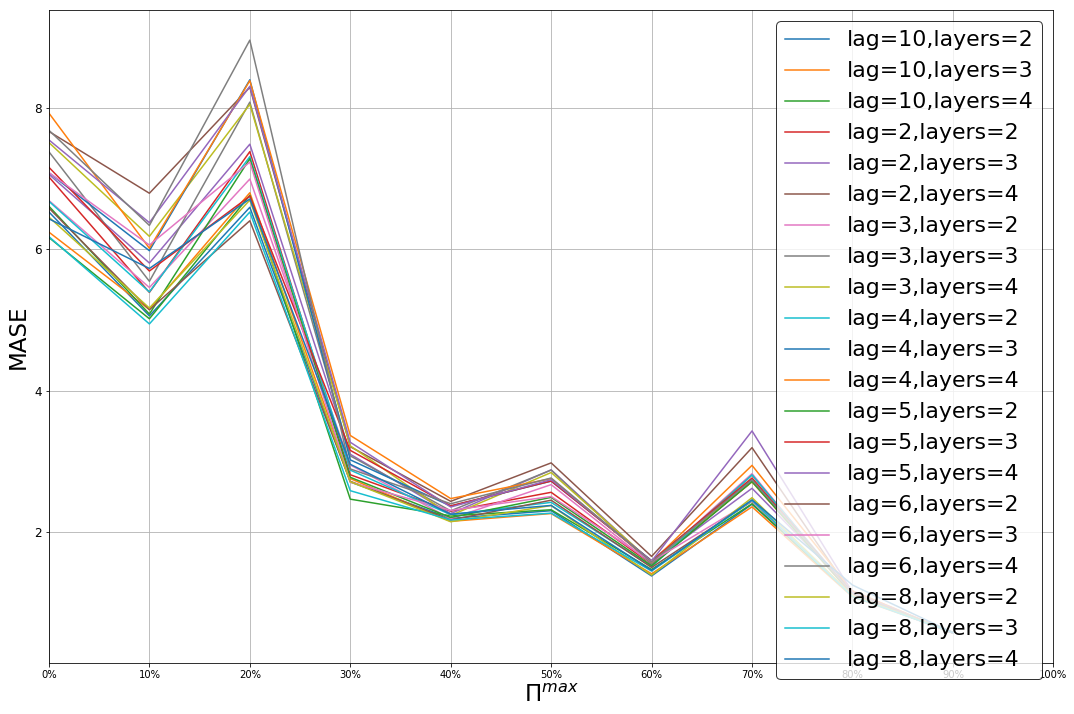

In [96]:
drawSeries_(reordered, r'$\Pi^{max}$', 'MASE', '', map(str, keys))

In [100]:
df = pd.DataFrame(sorted(counts.items(), key = lambda (k,v): (v, k)))
df.columns = [['Parameters', 'Rank']]
df

,Parameters,Rank
0,"lag=10,layers=2",25
1,"lag=8,layers=3",32
2,"lag=10,layers=3",41
3,"lag=10,layers=4",45
4,"lag=6,layers=2",47
5,"lag=8,layers=2",49
6,"lag=8,layers=4",71
7,"lag=5,layers=2",80
8,"lag=2,layers=2",89
9,"lag=3,layers=2",92
